Basin hopping Global Optimisation
=================================

Knowledge 
- https://machinelearningmastery.com/basin-hopping-optimization-in-python/

Random note
-----------
Take background as negative excursion

1) find background and modulation settings at x contrast
2) Use background and modulation settings as upper and lower bounds to find settings y%, where y% < x%
3) Use background and modulation settings at Y% as starting point for next Y%

Basic example with rosenbrock
-----------------------------

In [1]:
from scipy.optimize import rosen, basinhopping
bounds = [(0,2), (0, 2)]
result = basinhopping(rosen, bounds)
result.x, result.fun


(array([0.99999965, 0.99999926, 0.99999868, 0.99999757]),
 9.137792751824083e-12)

In [2]:
import sys
sys.path.insert(0, '../')
import random

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import basinhopping, Bounds
from scipy.interpolate import interp1d

from pysilsub.problem import SilentSubstitutionProblem as SSP
from pysilsub.CIE import get_CIES026

sns.set_context('notebook')
sns.set_style('whitegrid')


************************************************************
*************** Silent Substitution Problem ****************
************************************************************
Device: STLAB_1
Background: None
Ignoring: ['R']
Silencing: ['S', 'M', 'L']
Isolating: ['I']
Target contrast: None
Bounds:
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)


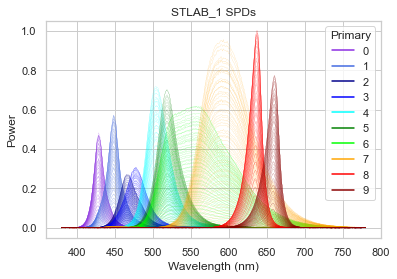

In [3]:
# Instantiate the class / define the problem
ssp = SSP.from_json('../bin/STLAB_1_config.json')
ssp.spds = ssp.spds.div(ssp.spds.max().max(), axis=0)
_ = ssp.plot_spds()

Do optimisation
---------------

In [ ]:
ssp.background = [.5] * 10
constraints = ({
    'type': 'eq',
    'fun': lambda x: ssp.silencing_constraint(x)
})


# List to store valid solutions
minima = []

def print_fun(x, f, accepted):
    print(f"Melanopsin contrast at minimum: {f}, accepted {accepted}")
    bg, mod = ssp.smlri_calculator(x)
    print(x)
    if accepted:
        minima.append(x)
        if f < -1. and accepted: # the target is 100% contrast
            return True
        
minimizer_kwargs = {
    'method': 'SLSQP',
    'bounds': ssp.bounds,
    'options': {'maxiter': 100},
    'constraints': constraints
}
    
# Do basinhopping
res = basinhopping(
    func=ssp.objective_function,
    x0=ssp.initial_guess_x0(),
    niter=100,
    T=1.0,
    stepsize=0.5,
    minimizer_kwargs=minimizer_kwargs,
    take_step=None,
    accept_test=None,
    callback=print_fun,
    interval=50,
    disp=True,
    niter_success=None,
    seed=None,
)

basinhopping step 0: f -0.0781964
Melanopsin contrast at minimum: -0.07819636319869086, accepted True
[ 0.41270858  0.20588991  0.95376499  0.92401375  0.30334881  0.79347844
  0.38085445  0.50218393  0.6355333   1.        ]
basinhopping step 1: f -0.180953 trial_f -0.180953 accepted 1  lowest_f -0.180953
found new global minimum on step 1 with function value -0.180953
Melanopsin contrast at minimum: -0.1809534630488503, accepted True
[ 0.29497272  0.15873836  0.9206665   1.          0.98922567  0.20963047
  0.33429702  0.55812346  0.992298    0.19502052]
basinhopping step 2: f -0.137242 trial_f -0.137242 accepted 1  lowest_f -0.180953
Melanopsin contrast at minimum: -0.1372417096327283, accepted True
[  1.03415837e-19   8.25364127e-01   1.42824276e-01   6.63677204e-01
   9.01710810e-01   5.59696414e-01   2.73919479e-01   5.08456933e-01
   9.84690615e-01   1.00000000e+00]
basinhopping step 3: f -0.118022 trial_f -0.118022 accepted 1  lowest_f -0.180953
Melanopsin contrast at minimum: -

In [ ]:
_ = ssp.plot_ss_result(res.x)